In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import actor_critic


In [2]:
from tensorflow.keras.initializers import RandomUniform as RU
from tensorflow.keras.layers import Dense, Input, concatenate, BatchNormalization
from tensorflow.keras import Model


In [3]:

from actor_critic import _actor_network,_critic_network, OrnsteinUhlenbeckActionNoise


from buffer import Replay_Buffer
import os
import gym
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Put these lines of code to avoid taking all the GPU memory by default
# (normally use a maximum of half of the GPU resources)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf.compat.v1.Session(config=config)


env = gym.make('Pendulum-v0')

state_dim = len(env.reset()) #dimension of the states
action_dim = 1  #dimension of the action vector
action_bound_range=1 #action is between -1 and 1
dflt_dtype='float32'
gamma=0.99 # discount factor

observ_min=env.observation_space.low
observ_max=env.observation_space.high

In [4]:
def take_action(state,rand):
#    action=actor.predict(state.ravel[0])
    action=actor.predict(state)
    if rand:
        return action+random.uniform(-action_bound_range, action_bound_range)
    else:
        return action+ actor_noise()

We create the actor and the critic NNs

In [5]:
#noise=OrnsteinUhlenbeckActionNoise
actor_learning_rate =0.0001
actor        = _actor_network(state_dim, action_dim,action_bound_range).model()
actor_target = _actor_network(state_dim, action_dim,action_bound_range).model()
actor_target.set_weights(actor.get_weights())
actor_opt = Adam(actor_learning_rate)
actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))


critic_learning_rate =0.001
critic_opt           = Adam(critic_learning_rate)
critic               = _critic_network(state_dim, action_dim).model()
critic_target        = _critic_network(state_dim, action_dim).model()
critic.compile(loss  ='mse', optimizer=critic_opt)
critic_target.set_weights(critic_target.get_weights())

#for switching 
tow = 0.001



Functions to train the networks.

In [6]:
def train_networks(states_batch, actions_batch, rewards_batch, next_states_batch, done_batch):
    next_actions = actor_target(next_states_batch)

    q_t_pls_1 = critic_target([next_states_batch, next_actions])
    y_i       = rewards_batch
    for i in range(batch_size):
        if not done_batch[i]:
            y_i[i] += q_t_pls_1[i] * gamma
    critic.train_on_batch([states_batch, actions_batch], y_i)
    
    with tf.GradientTape() as tape:
        a = actor(states_batch)
        tape.watch(a)
        q = critic([states_batch, a])
    dq_da = tape.gradient(q, a)
    
    with tf.GradientTape() as tape:
        a = actor(states_batch)
        theta = actor.trainable_variables
    da_dtheta = tape.gradient(a, theta, output_gradients=-dq_da)
    actor_opt.apply_gradients(zip(da_dtheta, actor.trainable_variables))

def update_target(target, online, tow):
    init_weights = online.get_weights()
    update_weights = target.get_weights()
    weights = []
    for i in tf.range(len(init_weights)):
        weights.append(tow * init_weights[i] + (1 - tow) * update_weights[i])
    target.set_weights(weights)
    return target

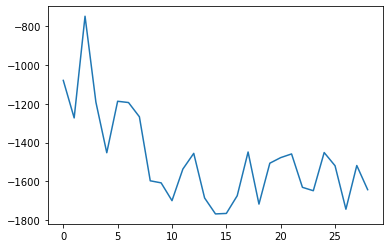

In [ ]:

rand=True
experience_cnt=0
explore_time=1000
#the buffer
max_buffer_size = 100000
batch_size=64
buffer = Replay_Buffer( max_buffer_size, batch_size, dflt_dtype)



    
r=[]
T=1000
n_episodes=1200
for episode in range(n_episodes):
    actor_noise.reset()
    ri, li, qlssi = [], [], []
    actions=[]
    state_t=np.array([env.reset()])
    state_t = (state_t - observ_min)/(observ_max-observ_min)
    for t in range(T):
        action_t = take_action(state_t, rand)
        actions.append(action_t)
        # step returns state_t+1, reward, done
        state_t_pls_1, rwrd_t, done_t,_ = env.step([action_t])
        ri.append(rwrd_t)
#        buffer.add_experience(
#                    state_t.ravel(), action_t, rwrd_t, np.array(state_t_pls_1,dflt_dtype), done_t)
        buffer.add_experience(
                    state_t.ravel(), action_t, rwrd_t, state_t_pls_1.ravel(), done_t)
        state_t = np.array(state_t_pls_1, dtype=dflt_dtype).reshape(1, state_dim)
        #if True:
        #print('t=%d episod=%d'% (t,n_episodes))
        if not rand:
                states_batch, actions_batch, rewards_batch, next_states_batch, done_batch = buffer.sample_batch()
                train_networks(states_batch, actions_batch, rewards_batch, next_states_batch, done_batch)
                actor_target = update_target(actor_target, actor, tow)
                critic_target = update_target(critic_target, critic, tow)
        if done_t or t == T-1:
            
            rr=np.sum(ri)
            r.append(rr)
            plt.plot(r)
            plt.show()
            clear_output(wait = True)

            #if episode% 1==0 :
            #    print('Episode %d : Total Reward = %f at time %d' % (episode, rr,t))
            break
        if rand: experience_cnt += 1
        if experience_cnt > explore_time: rand = False

In [ ]:
import matplotlib.pyplot as plt
plt.plot(r)
plt.show()

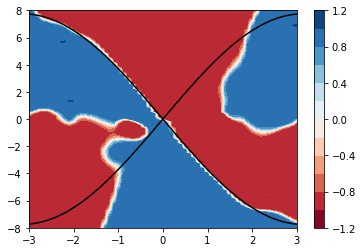

In [9]:
import math
x = np.arange(-3.0, 3.01, 0.1)
y = np.arange(-8.0, 8.01, 0.1)


Y, X = np.meshgrid(y, x)
Z=np.sin(X)

for i in range(0,Z.shape[0]):
    sTheta=math.sin(x[i])
    cTheta=math.cos(x[i])
    for j in range(0,Z.shape[1]):
        #print(x[i])
        Z[i,j]=actor.predict(np.array([[cTheta,sTheta,y[j]]]))
        #Z[i,j]=x[i]


#fig=plt.
fig, ax = plt.subplots()
#fig,ax=plt.figure(1)
cs=ax.contourf(X, Y, Z, 10, cmap='RdBu')
cbar = fig.colorbar(cs)

dtheta=np.sqrt(30*(1-np.cos(x)))
#plt.figure(1)
plt.plot(x,dtheta,color='black')
plt.plot(x,-dtheta,color='black')

plt.show()


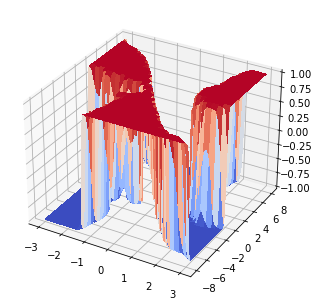

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
####%matplotlib notebook
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X,Y,Z,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


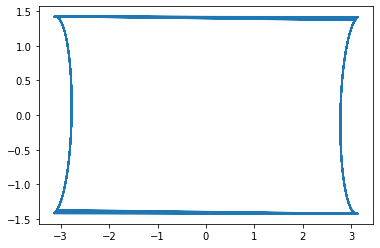

In [11]:
env.reset()
NT=1000
dat=np.zeros((NT, 3)) 
for i in range(NT):
    dat[i]=env.step([0])[0]
thetan=np.arctan2(dat[:,1],dat[:,0])
dthetan=dat[:,2]

fig, ax = plt.subplots()
plt.plot(thetan,dthetan)
plt.show()

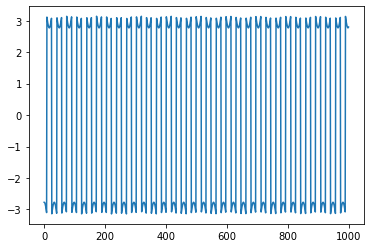

In [12]:
fig, ax = plt.subplots()


plt.plot(thetan)
plt.show()

In [ ]:
action_bound_range

# save a video with a test simulation